In [0]:
from pandas_datareader import data
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import os
from numpy import concatenate, square, sum
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt, ceil, floor
from keras import Sequential
from keras.regularizers import l1,l2,l1_l2
from keras.optimizers import Adam, SGD, Adadelta,RMSprop, Nadam
from keras.callbacks import EarlyStopping
from keras.initializers import glorot_normal
from keras.layers import Activation, Dense, LSTM, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor

drive.mount('/content/drive')
%cd drive/'My Drive'/'Colab Notebooks'

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


In [0]:
# memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()

In [0]:
# #load dataset and preliminary filters
df = pd.read_csv("dataraw.csv")

df.dropna(axis=1,thresh = len(df)*0.75, inplace= True)
    
df.dropna(axis=0,thresh = df.columns.size*0.75,inplace = True)

df.rename(index=str, inplace= True, columns={"Global Company Key - Company":"compkey", 'Historical CRSP PERMNO Link to COMPUSTAT Record': 'crspno', 'Data Year - Fiscal':'year'})

df = (df.fillna(method='ffill') + df.fillna(method='bfill'))/2

df.dropna(axis=1,inplace= True)

# #for merging drop the day component of the date
df['Date of Observation'] = df['Date of Observation'].apply(lambda x: int(str(x)[:6]))

# #drop observation which dont have the max # observations
df['num_obs'] = df.groupby('compkey')['compkey'].transform('count')
df = df[df['num_obs'] == df['num_obs'].max()]

# #drop constant columns
df = df.loc[:, (df != df.iloc[0]).any()]

# #drop unnecessary variables
df = df.drop(['Adjusted r-squared','crspno','year','Data Date', 'Report Date of Quarterly Earnings','woGW', 'Delisting Return','Exchange Code'\
             ,'Shares Outstanding','Volume', 'Special Items','eamonth', 'grGW'], axis=1)

# # merge with the other one
welch = pd.read_excel('welch.xlsx')
welch['tms'] = welch['lty'] - welch['tbl']
welch['dfy'] = welch['BAA'] - welch['AAA']
welch['d/p'] = welch['D12'].apply(np.log) - welch['Index'].apply(np.log)
welch['e/p'] = welch['E12'].apply(np.log) - welch['Index'].apply(np.log)

welch = welch[['yyyymm','d/p','e/p','b/m','ntis','tbl','tms','dfy','svar']]

## they never merge it
df_m = df.merge(welch,how='inner',left_on='Date of Observation',right_on='yyyymm')
df_m = df_m.drop('yyyymm', axis =1)

for x in df:
  for y in welch:
      if x == 'Date of Observation' or x == 'Return' or x == 'compkey' or y == 'yyyymm':
        continue
      else:
        name = str(x) + str(y)
        df_m[name] = df_m[x] * df_m[y]

df = df_m

df = (df.fillna(method='ffill') + df.fillna(method='bfill'))/2

In [0]:
def getvals(id, lags):
  stock = df[df['compkey']== id]
  stock= stock.sort_values(by='Date of Observation')
  stock = stock.drop(['compkey','Date of Observation'], axis= 1)
  stock = stock.assign(Returns_lagged=stock['Returns'].shift(lags).values)
  stock = stock.drop(stock.index[lags:])
  stock = stock[[c for c in stock if c not in ['Returns', 'Returns_lagged']] + ['Returns', 'Returns_lagged']]
  vals = stock.values
  return vals

def splitsets(vals, train_perc,valid_perc, lstm= False):
  n_train = floor(vals.shape[0]*train_perc)
  n_val = floor(n_train + vals.shape[0]*valid_perc)
  train = vals[:n_train,:]
  valid = vals[n_train:n_val,:]
  test = vals[n_val+1:,:]
  train_X, train_y = train[:, :-1], train[:, -1]
  valid_X , valid_y = valid[:,:-1], valid[:,-1]
  test_X, test_y = test[:, :-1], test[:, -1]
  if lstm:
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    valid_X = valid_X.reshape((valid_X.shape[0],1, valid_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

  return train_X, train_y , valid_X, valid_y, test_X, test_y


# batch normalization, learning rate shrinkage, early stopping
def nn_build_compile(optimizer='Adam',train_X= np.zeros((375,944)), init_mode='glorot_uniform', reg_1 = 0.001, reg_2 = 0, learn= 0.01,\
                     n_epoch= 200,decay = 0, dropout = 0.1,activation_1 ='relu', activation_2='linear', num_layers = 3):
  model = Sequential()
  for i in range(num_layers):
    model.add(Dense(int(32/2**i),kernel_initializer = init_mode, kernel_regularizer = l1_l2(l1=reg_1, l2=reg_2),activation= activation_1))
    model.add(Dropout(dropout))
  if optimizer == 'Adam':
    optimizer = Adam(lr= learn)
  if optimizer == 'Adadelta':
    optimizer = Adadelta(lr= learn)
  if optimizer == 'Nadam':
    optimizer = Nadam(lr=learn)
  if optimizer == 'RMSprop':
    optimizer = RMSprop(lr=learn)
  model.compile(loss='mse', optimizer= optimizer, metrics=['accuracy']) 
  return model

def lstm_build_compile(optimizer= 'Adam',train_X= np.zeros((375, 1, 944)), init_mode='glorot_uniform', reg_1 = 0.001, reg_2 = 0,\
                       learn= 0.01, n_epoch= 200,decay = 0, dropout = 0.1, activation_1 ='relu', activation_2='linear'):
  model = Sequential()
  model.add(LSTM(32,kernel_initializer = init_mode,input_shape = (train_X.shape[1],train_X.shape[2]),\
                 kernel_regularizer = l1_l2(l1=reg_1, l2=reg_2),return_sequences= True))
  model.add(Dropout(dropout))
  model.add(LSTM(16,kernel_initializer = init_mode,input_shape = (train_X.shape[1],train_X.shape[2]),\
                 kernel_regularizer = l1_l2(l1=reg_1, l2=reg_2), return_sequences= True ))
  model.add(Dropout(dropout))
  model.add(LSTM(8, input_shape = (train_X.shape[1], train_X.shape[2]), return_sequences = False))
  model.add(Dropout(dropout))
  model.add(Dense(1, kernel_initializer = init_mode, kernel_regularizer = l1_l2(l1=reg_1, l2=reg_2)))
  if optimizer == 'Adam':
    optimizer = Adam(lr= learn)
  if optimizer == 'Adadelta':
    optimizer = Adadelta(lr= learn)
  if optimizer == 'Nadam':
    optimizer = Nadam(lr=learn)
  if optimizer == 'RMSprop':
    optimizer = RMSprop(lr=learn)
  model.compile(loss='mse', optimizer= optimizer, metrics=['accuracy'])
  
  return model
  
def find_RMSE_plot(test_X, test_y,yhat, lstm= False):
  # invert scaling for forecast
  if lstm:
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
  inv_yhat = concatenate((test_X,yhat), axis=1) #test_X[:,1:]
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,-1]
  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), 1))
  inv_y = concatenate((test_X,test_y), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,-1]
  # calculate RMSE
  rsquare = 1- np.sum(np.square(inv_y - inv_yhat))/ np.sum(np.square(inv_y))
  print('Test R-square: %.3f' % rsquare)

  plt.plot(inv_y, label='true value')
  plt.plot(inv_yhat, label='prediction')
  plt.legend()
  plt.show()
  
def plot_loss(history):
  plt.plot(history.history['loss'], label='train') 
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()

In [0]:
## section for grid search
es = EarlyStopping(monitor='loss', verbose=1, patience = 100, restore_best_weights=True)
num_epoch = 400
train_perc = 0.825
valid_perc = 0.15
max_obs= [2049,1633,6821,4771,9882,1686,8850,1678,4737,9850,6781,3708, 10860]

for stock in max_obs:  # shift should be negative!
  vals = getvals(stock,-1)

    #scaling needs to be done outside
  n_train = floor(vals.shape[0]*train_perc)
  n_val = floor(n_train + vals.shape[0]*valid_perc)
  scaler = MinMaxScaler()
  vals[:n_val,:] = scaler.fit_transform(vals[:n_val,:])
  vals[n_val:,:] = scaler.transform(vals[n_val:,:])

  #LSTM
  train_X, train_y , valid_X, valid_y, test_X, test_y = splitsets(vals,train_perc,valid_perc, lstm = False)
  
  model = KerasRegressor(build_fn=nn_build_compile, epochs= num_epoch, verbose=0, shuffle=False)

  #Grid Search
#   init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
#   #things to optimize: hidden layers, hidden neurons, activation, maybe optimizer
#   #think about running multiple networks like the paper
#   reg_1 = [0,0.001,0.01]  
#   reg_2 = [0,0.001,0.01]
  layers = [1,2,3,4,5]
#   dropout = [0, 0.1, 0.2, 0.3, 0.4]
#   activation_1= ['relu','sigmoid','tanh','linear']
#   activation_2= ['relu','sigmoid','tanh','linear']
#   learn= [0.1,0.01,0.001,0.0001,0.00001]
#   optimizer = ['Adadelta','Adam', 'Nadam', 'RMSprop']
  param_grid = dict(num_layers=layers)
  grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring="neg_mean_squared_error", cv=3, n_jobs =-1)
  grid_result = grid.fit(train_X, train_y, callbacks= [es])
#   summarize results
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

ValueError: ignored

In [0]:
es = EarlyStopping(monitor='val_loss', verbose=1, patience = 100, restore_best_weights=True)
train_perc = 0.825
n_epoch = 10000
reg_1 = 0.001
reg_2 = 0
learn = 0.1
valid_perc = 0.15
max_obs= [2049,1633,6821,4771,9882,1686,8850,1678,4737,9850,6781,3708, 10860]

for stock in max_obs:
  
  # shift should be negative!
  vals = getvals(stock,-1)

  #scaling needs to be done outside
  n_train = floor(vals.shape[0]*train_perc)
  n_val = floor(n_train + vals.shape[0]*valid_perc)
  scaler = MinMaxScaler()
  vals[:n_val,:] = scaler.fit_transform(vals[:n_val,:])
  vals[n_val:,:] = scaler.transform(vals[n_val:,:])

  #Vanilla NN
  train_X, train_y , valid_X, valid_y, test_X, test_y = splitsets(vals,train_perc,valid_perc, lstm = False)
  
  # design network
  model = nn_build_compile(train_X, n_epoch = n_epoch, reg_1 = reg_1, reg_2 = reg_2)
   
  # fit network
  history = model.fit(train_X, train_y, epochs= n_epoch, batch_size=32, validation_data=(valid_X, valid_y), verbose=0, shuffle=False, callbacks= [es])
  # plot history
  plot_loss(history)

  yhat = model.predict(test_X)

  find_RMSE_plot(test_X,test_y,yhat, lstm = False)

  #LSTM
  train_X, train_y , valid_X, valid_y, test_X, test_y = splitsets(vals,train_perc, valid_perc, lstm= True)

  # design network
  model = model_build_compile(train_X, lstm = True, reg_1 = reg_1)

  # fit network
  history = model.fit(train_X, train_y, epochs= n_epoch, batch_size=32, validation_data=(valid_X, valid_y), verbose=0, shuffle=False, callbacks= [es])
  # plot history
  plot_loss(history)

  # make a prediction
  yhat = model.predict(test_X)

  find_RMSE_plot(test_X,test_y,yhat, lstm = True)

KeyboardInterrupt: ignored

In [0]:
# test_data = mid_prices[11000:]
vals = stock.values
n_train = floor(vals.shape[0]*0.7)
n_val = floor(n_train + vals.shape[0]*0.15)
vals[:n_val,:] = scaler.fit_transform(vals[:n_val,:])
vals[n_val:,:] = scaler.transform(vals[n_val:,:])

train = vals[:n_train,:]
valid = vals[n_train:n_val,:]
test = vals[n_val:,:]
[n,d] = train.shape

# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data w.r.t training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Train the Scaler with training data and smooth data 
smoothing_window_size = 20 # 2500
for di in range(0,n-n%smoothing_window_size,smoothing_window_size): # FIXX!!
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data 
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [0]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(11000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [0]:
D = d # Dimensionality of the data. Since our data is 1-D this would be 1
num_unrollings = 20 # Number of time steps you look into the future.
batch_size = 30 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

In [0]:
# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

In [0]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

In [0]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of 
# a specific format. Read more at: https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

In [0]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


In [0]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


In [0]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [1.0000000e-01 1.0981854e-03 2.7525683e-05 2.7533850e-05 2.7535481e-05]

	Output: [1.4508370e-01 9.9136890e-04 3.8703885e-05 2.7532056e-05 2.7530245e-05]


Unrolled index 1
	Inputs:  [1.0879354e-01 9.9136890e-04 2.7535743e-05 2.7535671e-05 2.7535896e-05]

	Output: [1.4508370e-01 8.0880319e-04 3.0020492e-05 2.7532056e-05 3.0020492e-05]


Unrolled index 2
	Inputs:  [1.4508370e-01 8.9498522e-04 3.0020492e-05 2.7532056e-05 2.7529839e-05]

	Output: [1.5526882e-01 5.9705647e-04 3.8703885e-05 3.0020492e-05 2.7530245e-05]


Unrolled index 3
	Inputs:  [1.5132882e-01 8.0880319e-04 2.7531420e-05 3.0020492e-05 2.7530245e-05]

	Output: [1.5132882e-01 8.0880319e-04 2.7535130e-05 2.7533879e-05 2.7634287e-05]


Unrolled index 4
	Inputs:  [1.5526882e-01 7.3067989e-04 3.8703885e-05 2.7531849e-05 3.0020492e-05]

	Output: [1.4462069e-01 5.4010411e-04 2.4758136e-05 2.7533879e-05 2.7531465e-05]


In [0]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 50 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings) 

x_axis_seq = []

# Points you start our test predictions from
test_points_seq = np.arange(11000,12000,50).tolist() 

for ep in range(epochs):       
    
    # ========================= Training =====================================
    for step in range(train_seq_length//batch_size):
        
        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)
        
        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l
    
    # ============================ Validation ==============================
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))
      
      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))
      
      train_mse_ot.append(average_loss)
            
      average_loss = 0 # reset loss
      
      predictions_seq = []
      
      mse_test_loss_seq = []
      
      # ===================== Updating State and Making Predicitons ========================
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []
        
        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]
        
        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)
        
        feed_dict = {}
        
        current_price = all_mid_data[w_i-1]
        
        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)
        
        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)
        
          our_predictions.append(np.asscalar(pred))
        
          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2
        
        session.run(reset_sample_states)
        
        predictions_seq.append(np.array(our_predictions))
        
        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)
        
        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)
        
      current_test_mse = np.mean(mse_test_loss_seq)
      
      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0
      
      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')
      
      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')

Initialized


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


ValueError: ignored

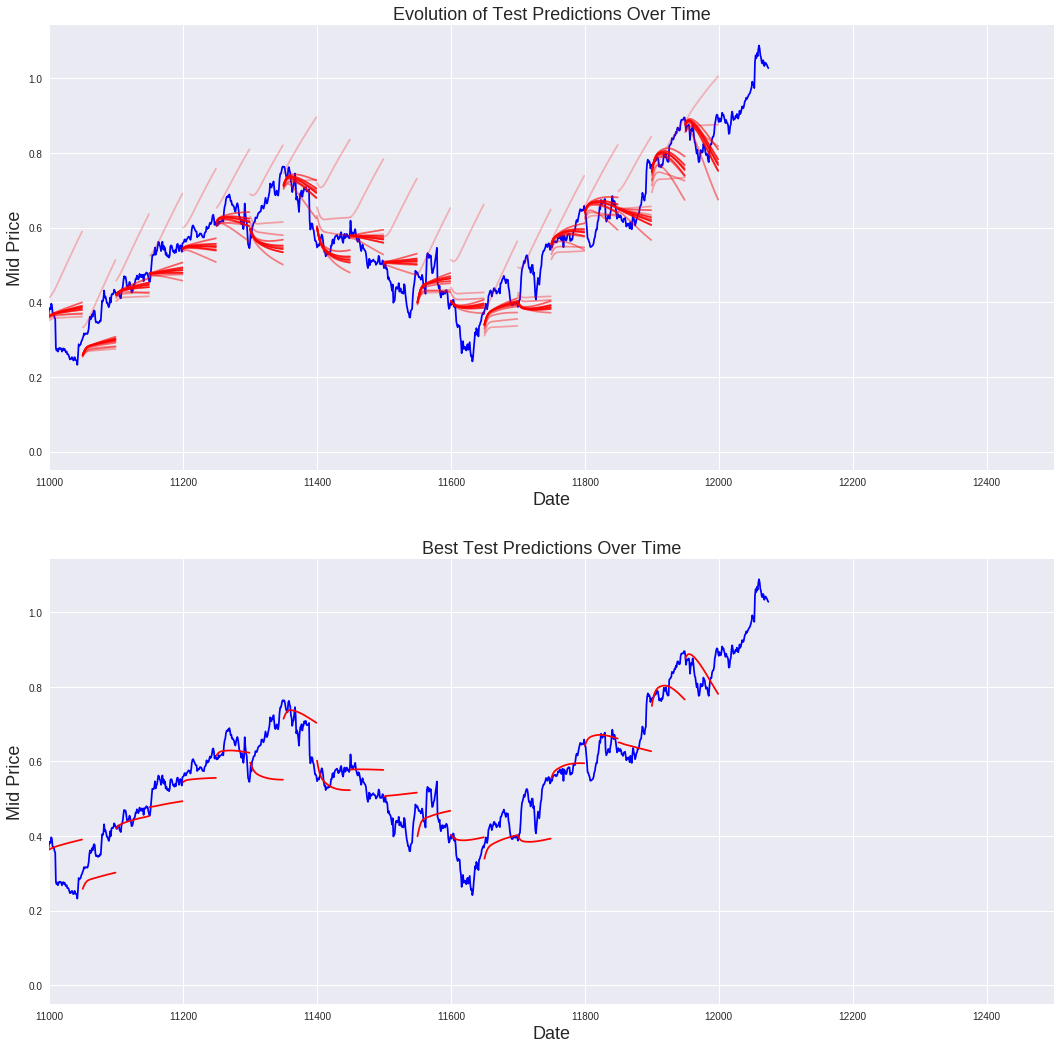

In [0]:
best_prediction_epoch = 16 # replace this with the epoch that you got the best results when running the plotting code

plt.figure(figsize = (18,18))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')
    
plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(11000,12500)
plt.show()